In [305]:
import os
import re
import string

import pandas as pd
import numpy as np

from collections import  Counter

import sklearn
from sklearn.model_selection import  train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import regularizers
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

os.chdir("D:\\Level 4\\PROJECT\\PetProjects\\HateSpeechlstm\\")

In [309]:
#import training data set
main_data=pd.read_csv("mytraining.csv")
data=main_data.copy()
data.drop(columns=['id'],axis=1,inplace=True)
data

,label,tweet
0,0,"Yes, you! Baboon, baboon, baboon, baboon!"
1,0,"Did you hear that, Marge? She called me a baboon! The stupidest, ugliest, smelliest ape of them all!"
2,0,Nuts.
3,0,Mmm... hors doovers.
4,0,You stink! You and your whole lousy operation stinks! I quit!
...,...,...
1994,1,"La, la, l- Oop."
1995,1,"Oh, well... let's sell it anyway."
1996,1,"Yo, check this out. Black guys drive a car like this. Yeah, but white guys, see they drive a car like this."
1997,1,It is time to settle the score.


,label
1,1214
0,785


0s : 1s  ::   0.65 : 1


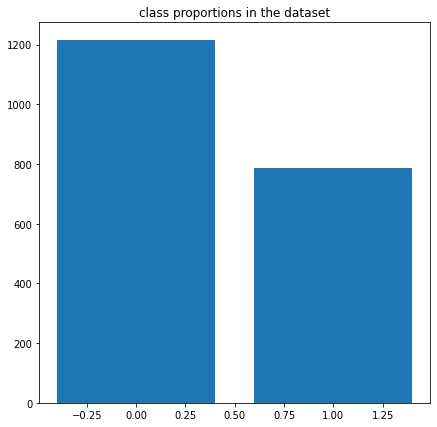

In [310]:
#Check class distribution in dependent variable 
#0-hatespeech 1-normal
display(data['label'].value_counts().to_frame())
print("0s : 1s  ::  ",(data['label'].value_counts()[0]/data['label'].value_counts()[1]).round(2),": 1")
plt.bar([0,1],data['label'].value_counts())
plt.title("class proportions in the dataset")
plt.show()

,label
1,21852
0,7065


0s : 1s  ::   0.32 : 1


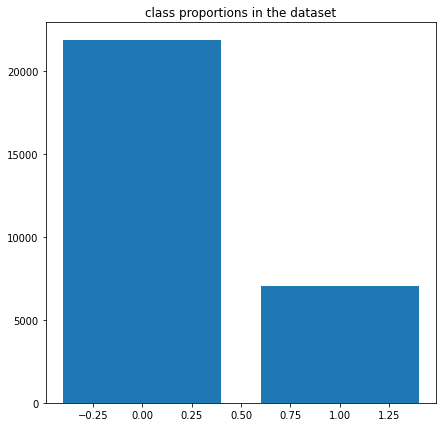

In [401]:

#Balancing the dataset using Oversampling - duplicating the minority dataset
data1=data[data['label']==1]
data0=data[data['label']==0]
data=pd.concat([data,data1], axis=0)
data

#Check class distribution in dependent variable again
display(data['label'].value_counts().to_frame())
print("0s : 1s  ::  ",(data['label'].value_counts()[0]/data['label'].value_counts()[1]).round(2),": 1")
plt.bar([0,1],data['label'].value_counts())
plt.title("class proportions in the dataset")
plt.show()

In [402]:
#remove emojis in text
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    return emoji_pattern.sub(r'', text)


def clean_text(text ): 
    #remove punctuations
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = text.translate(table)
    textArr= text1.split()
    #remove stop words. words with more than 3 letters is taken into account
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>3))]) 
    
    return text2.lower()

In [403]:

#preprocess train dataset - preprocessing the tweet column
data['tweet'] = data['tweet'].apply(remove_emoji)
data['tweet'] = data['tweet'].apply(clean_text)
data['Num_words_text'] = data['tweet'].apply(lambda x:len(str(x).split())) 

#split data into train and test columns
train_data,test_data= train_test_split(data, test_size=0.2)
train_data.reset_index(drop=True,inplace=True)
test_data.reset_index(drop=True,inplace=True)

In [404]:

#classes proportion in dependent variable in train and test dataset
#calculate the class distribution of train data
print('===========Train Data =========')
print(train_data['label'].value_counts())
print(len(train_data))
print('==============================')

#calculate the class distribution of test data
print('===========Test Data =========')
print(test_data['label'].value_counts())
print(len(test_data))
print('==============================')

===========Train Data =========
1    17466
0     5667
Name: label, dtype: int64
23133
===========Test Data =========
1    4386
0    1398
Name: label, dtype: int64
5784


In [405]:
#train data is again divided -train and validation dataset splitting
X_train, X_valid, y_train, y_valid = train_test_split(train_data['tweet'].tolist(),\
                                                      train_data['label'].tolist(),\
                                                      test_size=0.2,\
                                                      stratify = train_data['label'].tolist(),\
                                                      random_state=0)


#check the classs distributions
print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(Counter(y_valid)))

Train data len:18506
Class distributionCounter({1: 13972, 0: 4534})
Valid data len:4627
Class distributionCounter({1: 3494, 0: 1133})


In [406]:
#initialize the number of words - the maximum number of words you can have
num_words = 50000

#creating a tokenizer
tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(X_train)

In [407]:
#convert sentences to sequences of numbers
x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
x_test  = np.array( tokenizer.texts_to_sequences(test_data['tweet'].tolist()) )

#padding 
maxlen=50
x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_valid = pad_sequences(x_valid, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)


train_labels = np.asarray(y_train)
valid_labels = np.asarray(y_valid)
test_labels = np.asarray(test_data['label'].tolist())


print('Train data len:'+str(len(x_train)))
print('Class distribution'+str(Counter(train_labels)))

print('Validation data len:'+str(len(x_valid)))
print('Class distribution'+str(Counter(valid_labels)))

print('Test data len:'+str(len(x_test)))
print('Class distribution'+str(Counter(test_labels)))

#tensorflow dataset preparation
train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

Train data len:18506
Class distributionCounter({1: 13972, 0: 4534})
Validation data len:4627
Class distributionCounter({1: 3494, 0: 1133})
Test data len:5784
Class distributionCounter({1: 4386, 0: 1398})


In [408]:
#visualization of tensorflow dataset
count =0
print('======Train dataset ====')
for value,label in train_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Validation dataset ====')
for value,label in valid_ds:
    count += 1
    print(value,label)
    if count==1:
        break
count =0
print('======Test dataset ====')
for value,label in test_ds:
    count += 1
    print(value,label)
    if count==1:
        break

======Train dataset ====
tf.Tensor(
[368  71   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0], shape=(50,), dtype=int32) tf.Tensor(0, shape=(), dtype=int32)
======Validation dataset ====
tf.Tensor(
[121  46   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0], shape=(50,), dtype=int32) tf.Tensor(0, shape=(), dtype=int32)
======Test dataset ====
tf.Tensor(
[   7 1227 3068 3069 2282  348    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0], shape=(50,), dtype=int32) tf.Tensor(0, shape=(), dtype=int32)


In [409]:
#model preparation
#maximum vocabulary is set to 50000
max_features =50000
#embedding dimensions - every word is converted into 16 bit vectors
embedding_dim =16
sequence_length = maxlen

model = tf.keras.Sequential()
#embedding layer
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.005))) 
#dropout later to handle overfitting by removing certain bits from 16 bit vector
model.add(tf.keras.layers.Dropout(0.4))

#LSTM LAYER
model.add(tf.keras.layers.LSTM(embedding_dim,dropout=0.2, recurrent_dropout=0.2,return_sequences=True,\
                                                             kernel_regularizer=regularizers.l2(0.005),\
                                                             bias_regularizer=regularizers.l2(0.005)))

model.add(tf.keras.layers.Flatten())

#hidden layers
#512 nodes
model.add(tf.keras.layers.Dense(512, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))

#8 nodes
model.add(tf.keras.layers.Dense(8, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
                               


#compliling
model.summary()
#BinaryCrossentropy - 1 or 0 - normal or hate
#optimizer -adam
#metrics - BinaryAccuracy - predictions below 0.5 to 0 and above 0.5 to 1
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),optimizer=tf.keras.optimizers.Adam(1e-3),metrics=[tf.keras.metrics.BinaryAccuracy()])

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 50, 16)            800016    
_________________________________________________________________
dropout_45 (Dropout)         (None, 50, 16)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 50, 16)            2112      
_________________________________________________________________
flatten_15 (Flatten)         (None, 800)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 512)               410112    
_________________________________________________________________
dropout_46 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 8)               

In [410]:
epochs = 10
# Fit the model using the train and test datasets.
history = model.fit(train_ds.shuffle(5000).batch(1024),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(1024),
                    verbose=1)

Epoch 1/10
19/19 [==============================] - 3s 149ms/step - loss: 3.2962 - binary_accuracy: 0.7466 - val_loss: 1.9233 - val_binary_accuracy: 0.7551
Epoch 2/10
19/19 [==============================] - 3s 135ms/step - loss: 1.4077 - binary_accuracy: 0.7550 - val_loss: 0.9809 - val_binary_accuracy: 0.7551
Epoch 3/10
19/19 [==============================] - 3s 137ms/step - loss: 0.8531 - binary_accuracy: 0.7550 - val_loss: 0.7181 - val_binary_accuracy: 0.7551
Epoch 4/10
19/19 [==============================] - 3s 134ms/step - loss: 0.6432 - binary_accuracy: 0.7613 - val_loss: 0.5157 - val_binary_accuracy: 0.8260
Epoch 5/10
19/19 [==============================] - 3s 136ms/step - loss: 0.4874 - binary_accuracy: 0.8764 - val_loss: 0.3980 - val_binary_accuracy: 0.9646
Epoch 6/10
19/19 [==============================] - 3s 135ms/step - loss: 0.3674 - binary_accuracy: 0.9449 - val_loss: 0.2668 - val_binary_accuracy: 0.9892
Epoch 7/10
19/19 [==============================] - 3s 137ms/ste

In [389]:
#make predictions on validation dataset
valid_predict= model.predict(x_valid)
print(valid_predict[:10])

[[5.6546596e-06]
 [3.8618673e-05]
 [4.1484833e-04]
 [9.9999505e-01]
 [9.9999267e-01]
 [9.9999160e-01]
 [2.2998452e-04]
 [4.2376128e-06]
 [9.9998242e-01]
 [9.9999642e-01]]


In [390]:
#model's metrics on test dataset
x_test  = np.array( tokenizer.texts_to_sequences(test_data['tweet'].tolist()) )
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)


#Generate predictions for all samples
predictions = model.predict(x_test)

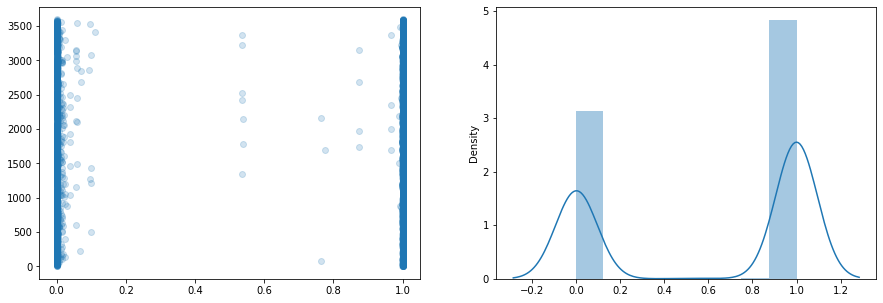

In [391]:

#plot predictions
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.scatter(predictions,range(0,len(predictions)),alpha=0.2)
ax2=sns.distplot(predictions)
#values are saturated around 0&1 classifying them as hate or normal

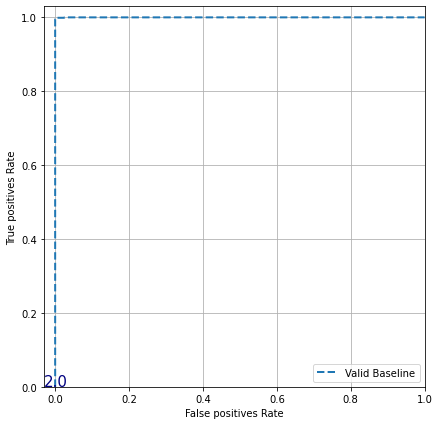

In [392]:
#decide the cutoff for classifying the predicted probabilities as 1 or 0
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, thresholds = sklearn.metrics.roc_curve(labels, predictions)
    plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives Rate')
    plt.ylabel('True positives Rate')
    plt.xlim([-0.03, 1.0])
    plt.ylim([0.0, 1.03])
    plt.grid(True)
    thresholdsLength = len(thresholds)
    thresholds_every = 1000
    colorMap = plt.get_cmap('jet', thresholdsLength)
    for i in range(0, thresholdsLength, thresholds_every):
        threshold_value_with_max_four_decimals = str(thresholds[i])[:5]
        plt.text(fp[i] - 0.03, tp[i] + 0.001, threshold_value_with_max_four_decimals, fontdict={'size': 15}, color=colorMap(i/thresholdsLength));

    ax = plt.gca()
    ax.set_aspect('equal')

mpl.rcParams['figure.figsize'] = (7,7)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_roc("Valid Baseline", valid_labels, valid_predict, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [393]:
cutoff=0.86
test_data['pred_sentiment']= predictions
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment >= cutoff),1,test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment < cutoff),0,test_data.pred_sentiment)

labels = [0, 1]
print(classification_report(test_data['label'].tolist(),test_data['pred_sentiment'].tolist(),labels=labels))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1417
           1       1.00      0.99      1.00      2182

    accuracy                           0.99      3599
   macro avg       0.99      0.99      0.99      3599
weighted avg       0.99      0.99      0.99      3599



In [394]:
#Testing Model on the test dataset

In [395]:
final_test=pd.read_csv("mytesting.csv")

ftest=final_test.copy()
ftest.drop(columns=['id'],axis=1,inplace=True)

ftest['tweet'] = ftest['tweet'].apply(remove_emoji)
ftest['tweet'] = ftest['tweet'].apply(clean_text)

f_test  = np.array( tokenizer.texts_to_sequences(ftest['tweet'].tolist()) )
f_test = pad_sequences(f_test, padding='post', maxlen=maxlen)

display((x_test))
display((f_test))

array([[   0,    0,    0, ...,    0,    0,    0],
       [   7,   23,   68, ...,    0,    0,    0],
       [ 100,    0,    0, ...,    0,    0,    0],
       ...,
       [ 241,    4, 1240, ...,    0,    0,    0],
       [ 437,  437,    0, ...,    0,    0,    0],
       [  48,  520,   48, ...,    0,    0,    0]])

array([[  81, 1268,   20, ...,    0,    0,    0],
       [ 445,  252,   71, ...,    0,    0,    0],
       [ 132,  606,  156, ...,    0,    0,    0],
       ...,
       [  28, 1247,    0, ...,    0,    0,    0],
       [  21,    1,    0, ...,    0,    0,    0],
       [  11,   11,  125, ...,    0,    0,    0]])

In [396]:

#predict on actual test data
predictions = model.predict(f_test)

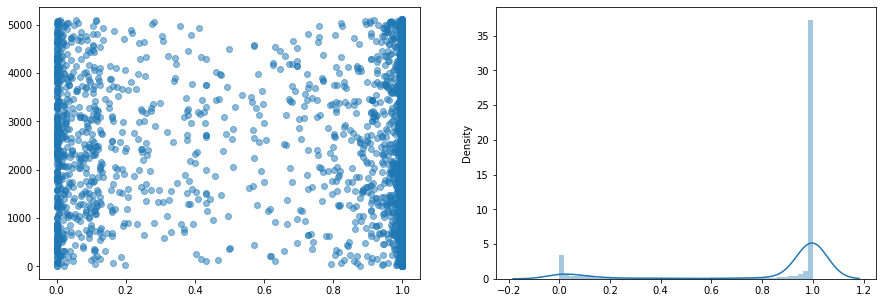

In [397]:

#plot predictions
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))
ax1.scatter(predictions,ftest.index,alpha=0.5)
ax2=sns.distplot(predictions)

In [400]:

#mapping prediction to 1 or 0
ftest['pred_sentiment']= predictions
ftest['pred_sentiment'] = np.where((ftest.pred_sentiment >= cutoff),1,ftest.pred_sentiment)
ftest['pred_sentiment'] = np.where((ftest.pred_sentiment < cutoff),0,ftest.pred_sentiment)

#processed tweets categorized as hate speech
pd.set_option('display.max_colwidth', None)
ftest[ftest['pred_sentiment']==0]

,tweet,pred_sentiment
1,theyve tried stop them seniors early morning they everything done before everyone else even awake,0.0
7,theyre coming here before they hills find fight them boys avenger avenger,0.0
11,sneak into town shut down their food supply here,0.0
29,heck this goin wellwere gonna take whole country back wipe everyone below sixty five,0.0
46,stop this partly your fault,0.0
...,...,...
5078,having investigated closely pope determined that blood coming from virgin marys rather from vagina pope said quote chick bleeding vagina miracle chicks bleed their vaginas time back,0.0
5082,heard what said higher power didnt cure powerless again,0.0
5091,yeah statue wasnt miracle that means that means didnt have drink five days your,0.0
5097,nothing easy learning drink little responsibly thatsa disciprine disciprine come from within,0.0


In [399]:
#actual tweets categorized as hate speech
final_test.iloc[ftest[ftest['pred_sentiment']==0].index]

,id,tweet
1,1980,"They've tried to stop them, son, but... the seniors get up so early in the morning they... get everything done before everyone else is even awake!\n"
7,1986,"They're coming!! Get out of here before they see you! Run to the hills and find a way to fight them! Go!! Boys, avenger me! AVENGER ME!!\n"
11,1990,No. But we can sneak into town and shut down their food supply. Here.\n
29,2008,Huh?? Heck no! This is goin' too well.We're gonna take the whole country back. Wipe out everyone below the age of sixty five!\n
46,2025,"Oh, stop it, Dad! This is partly your fault!\n"
...,...,...
5078,7057,"Having investigated closely, the pope determined that the blood was not coming from the Virgin Mary's ass, but rather, from her vagina. And the pope said quote, ""A chick bleeding out her vagina is no miracle. Chicks bleed out their vagina's all the time."" Back to you, Tom.\n"
5082,7061,You heard what he said! The higher power didn't cure me! I'm powerless again!\n
5091,7070,"Yeah. The statue wasn't a miracle, Dad. So that means you did it. That means you didn't have a drink for five days all on your own.\n"
5097,7076,"Naw. All or nothing is easy. But learning to drink a little bit, responsibly, that'sa disciprine. Disciprine... come from within. \n"
